<a href="https://colab.research.google.com/github/BharathSShankar/DSA4212_Assignments/blob/bharath-exp/deepEnsemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles](https://www.deepmind.com/publications/simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles) classification on MedMNIST.

In [1]:
!pip install medmnist torchmetrics
!python -m medmnist download

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=e65a974af10bfca9d4cafc75afed393901f099e037dc8d83af36191b2415d5b8
  Stored in directory: /root/.cache/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire
100% 205615438/205615438 [00:38<00:00, 5364859.47it/s]
100% 82802576/82802576 [00:17<00:00, 4854639.62it/s]
100% 19725078/19725078 [00:03<00:00, 5346391.70it/s]
100% 54938180/54938180 [00:12<00:00, 4464559.38it/s]
100% 4170669/4170669 [00:00<00:00, 5448863.65it/s]
100% 3291041/3291041 [00:00<00:00, 5600959.55it/s]
100% 559580/559580 [00:00<00:00, 4500736.62it/s]
100% 35461855/35461855 [00:06<00:00, 5408923.43it/s]

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import medmnist
from medmnist import INFO, Evaluator
import torch.utils.data as data
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import numpy as np

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # 3 channels, 16 filters, kernel size 3, stride 1, padding 1
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(32 * 7 * 7, num_classes)  # Update dimensions to 32 * 7 * 7

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Infer the size of the first dimension
        x = self.fc(x)
        return x


In [4]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device).squeeze()

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(dataloader), 100 * correct / total


In [5]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [6]:
# Load PathMNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_set = DataClass(split='train', transform=transform, download=download)
test_set = DataClass(split='test', transform=transform, download=download)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [7]:
# Set up device
device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Hyperparameters
num_epochs = 3
num_ensembles = 5

# Create and train ensemble models
models = []
for i in range(num_ensembles):
    model = SimpleCNN(num_classes=n_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"Training ensemble model {i + 1}/{num_ensembles}")
    for epoch in trange(1, num_epochs + 1):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss, accuracy = test(model, test_loader, criterion, device)
        print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

    models.append(model)


Training ensemble model 1/5


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1/3], Train Loss: 1.0540, Test Loss: 1.1758, Accuracy: 63.7047


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2/3], Train Loss: 0.7793, Test Loss: 0.8874, Accuracy: 80.3482


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [3/3], Train Loss: 0.6874, Test Loss: 0.9217, Accuracy: 77.1866
Training ensemble model 2/5


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1/3], Train Loss: 1.0660, Test Loss: 0.8733, Accuracy: 75.0836


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2/3], Train Loss: 0.7956, Test Loss: 1.1226, Accuracy: 66.3788


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [3/3], Train Loss: 0.6967, Test Loss: 0.8519, Accuracy: 74.0669
Training ensemble model 3/5


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1/3], Train Loss: 1.0577, Test Loss: 0.9926, Accuracy: 66.7967


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2/3], Train Loss: 0.7767, Test Loss: 0.8526, Accuracy: 76.0724


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [3/3], Train Loss: 0.6632, Test Loss: 0.7441, Accuracy: 78.6769
Training ensemble model 4/5


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1/3], Train Loss: 1.0788, Test Loss: 0.9351, Accuracy: 72.3120


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2/3], Train Loss: 0.7924, Test Loss: 0.8395, Accuracy: 76.6574


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [3/3], Train Loss: 0.7050, Test Loss: 0.8452, Accuracy: 77.9109
Training ensemble model 5/5


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1/3], Train Loss: 1.0610, Test Loss: 0.9246, Accuracy: 72.3398


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2/3], Train Loss: 0.8050, Test Loss: 0.9586, Accuracy: 71.6017


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [3/3], Train Loss: 0.7015, Test Loss: 0.7818, Accuracy: 80.8774


In [8]:
def ensemble_prediction(models, dataloader, device):
    model_preds = []
    targets = []
    
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device).squeeze()
                outputs = model(images)
                preds.extend(outputs.cpu().numpy())
        model_preds.append(preds)
    
    model_preds = np.stack(model_preds, axis=0)
    targets = np.array([label.item() for _, label in test_set])
    
    mean_preds = np.mean(model_preds, axis=0)
    uncertainty = np.std(model_preds, axis=0)
    
    return mean_preds, targets, uncertainty

mean_preds, targets, uncertainty = ensemble_prediction(models, test_loader, device)

# Calculate the ensemble accuracy
ensemble_accuracy = np.mean(np.argmax(mean_preds, axis=1) == targets)
print(f"Ensemble accuracy: {ensemble_accuracy:.4f}")

# Display an example of the uncertainty values
print(f"Uncertainty example: {uncertainty[:10]}")


Ensemble accuracy: 0.8343
Uncertainty example: [[1.21011    0.83636826 0.9121877  2.4851048  0.7610061  1.4542282
  1.2365916  1.3170276  1.8746287 ]
 [2.6104724  1.4236588  1.0511525  0.90969133 0.9639485  1.2433627
  0.9461337  1.0214022  0.9719811 ]
 [1.3258985  0.46756935 1.0598178  1.4425026  0.806735   1.2246196
  0.6154496  1.2229352  1.0826256 ]
 [1.3606865  1.5294564  0.66009456 1.00787    0.7376718  0.37675434
  0.52609783 0.9599716  0.44676396]
 [0.99375206 0.8930602  0.4998215  1.6107768  1.0030633  1.0493708
  1.0941143  1.1802466  0.9956955 ]
 [1.8241663  0.58073705 1.3506198  1.4961152  0.79808515 1.1979482
  1.0056238  1.3172828  1.599257  ]
 [1.3155047  1.3627244  0.8258032  1.3534166  0.7274292  0.9688122
  0.7939166  1.2677903  0.53350836]
 [0.90747344 1.261273   0.6011034  3.7073889  1.2759384  0.7549088
  1.2163491  1.0809518  0.8103126 ]
 [1.4455338  1.3476664  0.68928844 2.2364845  1.3680804  1.0803616
  1.649141   1.7421684  0.50784004]
 [1.1179637  0.8717734  0

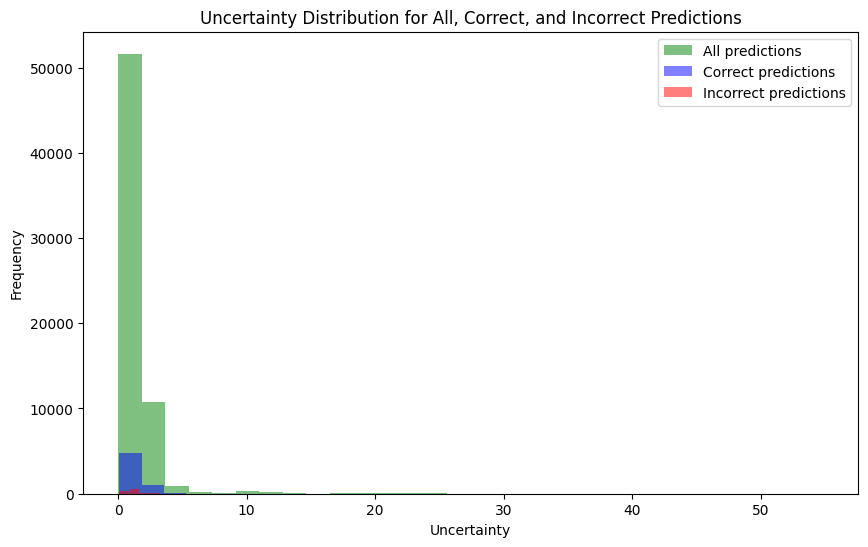

In [9]:
uncertainty = uncertainty.reshape(-1)  # Reshape the uncertainty array to be 1-dimensional

correct_indices = np.where(np.argmax(mean_preds, axis=1) == targets)[0]
incorrect_indices = np.where(np.argmax(mean_preds, axis=1) != targets)[0]

correct_uncertainties = uncertainty[correct_indices]
incorrect_uncertainties = uncertainty[incorrect_indices]

plt.figure(figsize=(10, 6))
plt.hist(uncertainty, bins=30, alpha=0.5, label="All predictions", color='green')
plt.hist(correct_uncertainties, bins=30, alpha=0.5, label="Correct predictions", color='blue')
plt.hist(incorrect_uncertainties, bins=30, alpha=0.5, label="Incorrect predictions", color='red')
plt.xlabel("Uncertainty")
plt.ylabel("Frequency")
plt.legend()
plt.title("Uncertainty Distribution for All, Correct, and Incorrect Predictions")
plt.show()


In [41]:
import torch

import torchmetrics

# Define the device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the batch size for the DataLoader
targets = []
model_preds = []

for model in models:
    model.eval()
    preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).squeeze()
            outputs = model(images)
            preds.extend(outputs.cpu().numpy())
            if len(targets) < 225:
                targets.append(labels.detach())
    model_preds.append(preds)
        

model_preds = np.stack(model_preds, axis=0)

mean_preds = np.mean(model_preds, axis=0)
uncertainty = np.std(model_preds, axis=0)

# Concatenate the targets and predicted probabilities
targets = torch.nn.functional.one_hot(torch.cat(targets))
mean_preds = torch.softmax(torch.Tensor(mean_preds), axis = 1)

# Calculate the ECE
ece = torchmetrics.functional.classification.binary_calibration_error(mean_preds, targets, 9)

AttributeError: ignored